# Лабораторная работа № 6
Используя явную схему крест и неявную схему, решить начально-краевую задачу для дифференциального уравнения гиперболического типа. Аппроксимацию второго начального условия произвести с первым и со вторым порядком. Осуществить реализацию трех вариантов аппроксимации граничных условий, содержащих производные: двухточечная аппроксимация с первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная аппроксимация со вторым порядком. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $U(x,t)$. Исследовать зависимость погрешности от сеточных параметров $\tau,h$.

### Вариант №5
**_Уравнение:_**
$$\frac{\partial^2 u}{\partial t^2} = 2\frac{\partial^2 u}{\partial x^2} + 4\frac{\partial u}{\partial x},$$

**_Граничные условия:_**
$$u(0,t) = 0,$$
$$u(\pi, t)= 0,$$
$$u(x, 0) = 0,$$
$$u_t(x, 0) = exp(-x)sin(x)$$

**_Аналитическое решение:_**
$$U(x,t)=0.5exp(-x)sin(x)sin(2t)$$

## Решение
**Импорты:**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 10]

**Параметры:**

In [2]:
a = np.sqrt(2)
b = 4
T = 2 * np.pi
l = np.pi
N = 20
sigma = 0.4
#-----------------#
h = l/N
tau = np.sqrt(sigma*h**2/(a*a))
K = int(round(T/tau))
X = np.array([i * h for i in range(N+1)])
delta = sigma * b * h / (2 * a ** 2) 

**Граничные условия и аналитическое решение**

In [3]:
def u_0_t():
    return 0

def u_pi_t():
    return 0

def u_x_0():
    return 0

def ut_x_0(x):
    return np.exp(-x) * np.sin(x)

def du_x_0(x):
    return 0

def ddu_x_0(x):
    return 0

def analytic_solution(x, t):
    return 0.5 * np.exp(-x) * np.sin(x) * np.sin(2 * t)

### Вспомогательные функции
**Нахождение ошибок (через max):**

In [4]:
def find_errors(grid):
    errors = np.zeros(K + 1)
    for i in range(K):
        u_from_solution = analytic_solution(X, i * tau)
        u_found = grid[i]
        errors[i] = np.amax(np.abs(u_from_solution - u_found))
    return errors

**Метод прогонки:**

In [5]:
def sweep_method(a, b):
    p = np.zeros(len(b))
    q = np.zeros(len(b))

    # прямой ход
    p[0] = -a[0][1]/a[0][0]
    q[0] = b[0]/a[0][0]
    for i in range(1, len(p)-1):
        p[i] = -a[i][i+1]/(a[i][i] + a[i][i-1]*p[i-1])
        q[i] = (b[i] - a[i][i-1]*q[i-1])/(a[i][i] + a[i][i-1]*p[i-1])
    p[-1] = 0
    q[-1] = (b[-1] - a[-1][-2]*q[-2])/(a[-1][-1] + a[-1][-2]*p[-2])

    # обратный ход
    x = np.zeros(len(b))
    x[-1] = q[-1]
    for i in reversed(range(len(b)-1)):
        x[i] = p[i]*x[i+1] + q[i]

    return x

**Построение графиков:**

In [6]:
def view_mode(grid, errors):
    
    x_array = X
    t_array = np.array([i*tau for i in range(K+1)])

    fig, (ax1, ax2) = plt.subplots(1, 2)

    t = [int(K * 0.05), int(K * 0.1), int(K * 0.25)]
    colors = ['green', 'blue', 'red']

    for i in range(len(t)):
        u_correct = analytic_solution(x_array, t[i]*tau)
        u_calculated = grid[t[i]]
        ax1.plot(x_array, u_correct, color=colors[i])
        ax1.plot(x_array, u_calculated, color=colors[i], linestyle = '--', label='t=%s'%round(t[i]*tau, 2))
        
    ax1.set_xlabel('x')
    ax1.set_ylabel('U(t, x)')
    ax1.grid()
    ax1.legend()
    ax2.plot(t_array[:-1], errors[:-1], color='black')
    ax2.set_xlim(0, 3)
    ax2.set_xlabel('t')
    ax2.set_ylabel('delta(t)')
    ax2.grid()  

### Явная схема

In [11]:
def explicit_scheme():
    grid = np.zeros((K + 1, N + 1))
    
    for j in range(N + 1):
        grid[0][j] = u_x_0()
        grid[1][j] = u_x_0() + ut_x_0(j*h)*tau + a**2 * ((tau**2)/2) * ddu_x_0(j*h) + b * ((tau**2)/2) * du_x_0(j*h)
        
    for i in range(1, K):
        grid[i][0] = u_0_t()
        grid[i][N] = u_pi_t()
    
    for i in range(2, K):
        for j in range(1, N):
            grid[i][j] = (sigma+delta)*grid[i-1][j+1]+2*(1-sigma)*grid[i-1][j]+(sigma-delta)*grid[i-1][j-1]-grid[i-2][j]
            
    return grid

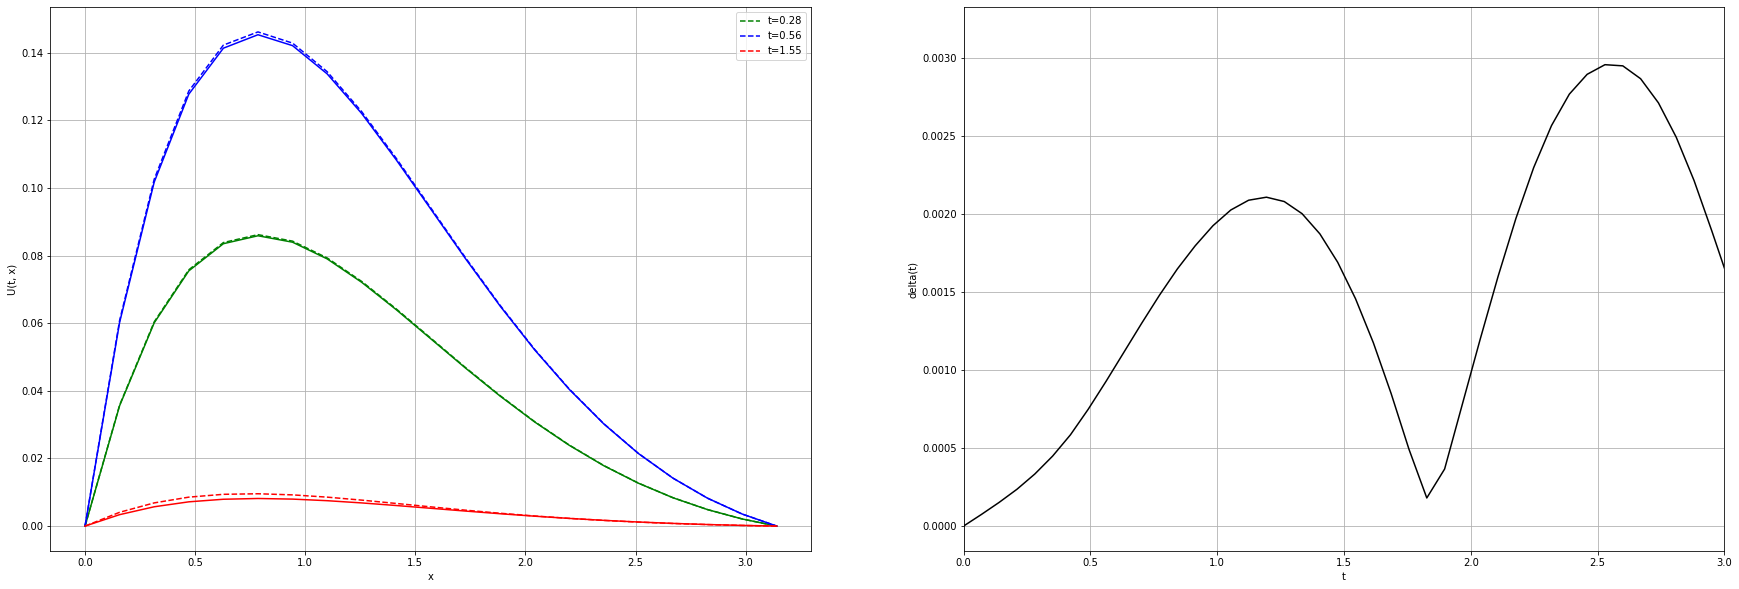

In [12]:
exp_grid = explicit_scheme()
exp_errors = find_errors(exp_grid)
view_mode(exp_grid, exp_errors)

---
### Неявная схема

In [9]:
def implicit_scheme():
    a_j = sigma - delta
    b_j = -(1+2*sigma)
    c_j = sigma + delta

    grid = np.zeros((K + 1, N + 1))
    
    for j in range(N+1):
        grid[0][j] = u_x_0()
        grid[1][j] = u_x_0() + tau * ut_x_0(j*h) + a**2 * ((tau**2)/2) * ddu_x_0(j * h) + b * ((tau**2)/2) * du_x_0(j*h)
    
    for i in range(2, K+1):
        grid[i][0] = u_0_t()
        grid[i][N] = u_pi_t()

    for i in range(2, K+1):
        M = np.zeros((N-1, N-1))
        d = np.zeros(N-1)

        M[0][0] = b_j
        M[0][1] = c_j
        d[0] = -2*grid[i-1][1] + grid[i-2][1] - (sigma-delta)*u_0_t()

        for j in range(1, N-2):
            M[j][j-1] = a_j
            M[j][j] = b_j
            M[j][j+1] = c_j
            d[j] = -2*grid[i-1][j+1] + grid[i-2][j+1]
        
        M[N-2][N-3] = a_j
        M[N-2][N-2] = b_j
        d[N-2] = -2*grid[i-1][N-1] + grid[i-2][N-1] - (sigma+delta)*u_0_t()

        solve = sweep_method(M, d)
        grid[i][1:N] = solve

    return grid

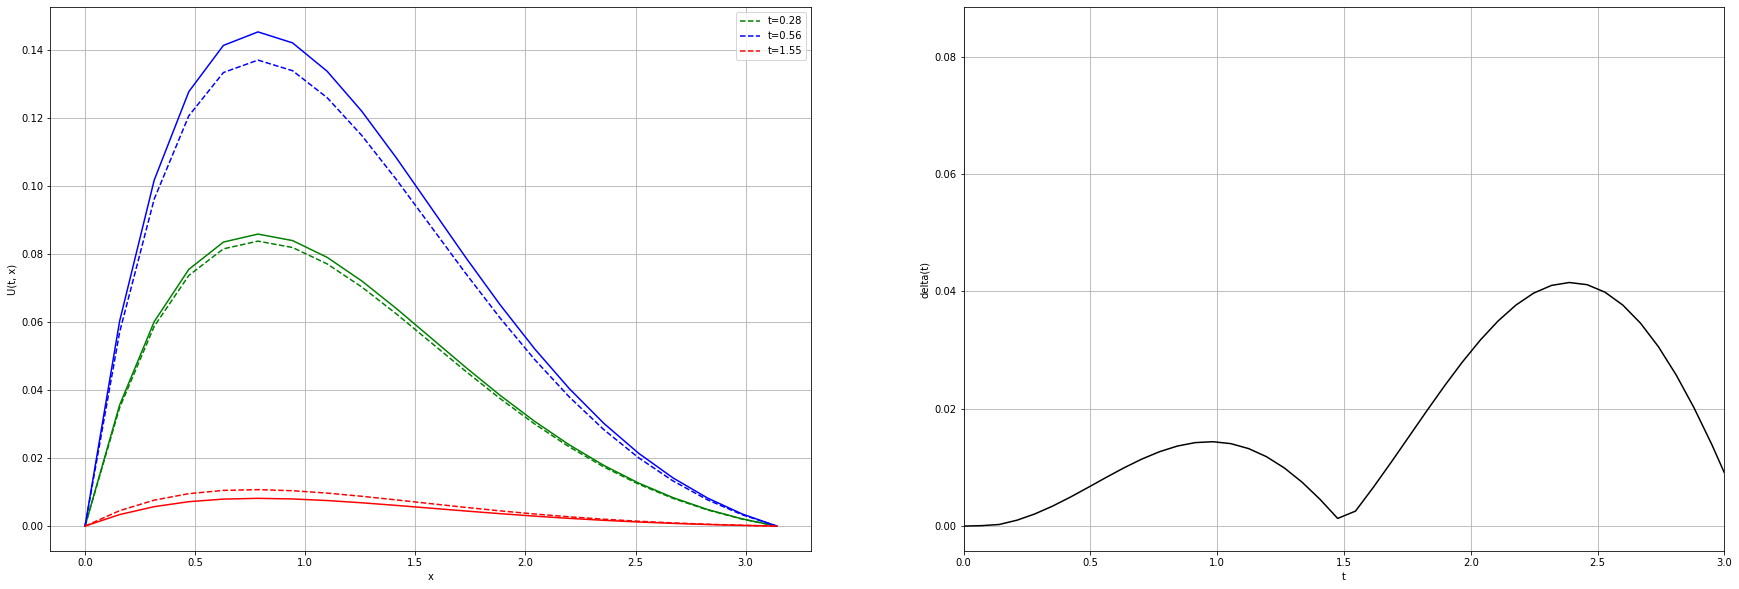

In [10]:
imp_grid = implicit_scheme()
imp_errors = find_errors(imp_grid)
view_mode(imp_grid, imp_errors)